# 모델 비교

아래 세가지를 방법을 이용해 학습한 모델을 비교한다.

- 요약 지표
- 성능 시각화
- 데이터셋 시각화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
np.random.seed(35)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    get_vectorized_series, 
    get_feature_vector_and_label
)
from ml_editor.model_evaluation import get_feature_importance, get_calibration_plot
from ml_editor.model_v2 import POS_NAMES

data_path = Path('./data/processed/writers/writers_with_features.csv')
df = pd.read_csv(data_path)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
clf_1 = joblib.load(Path("./models/model_1.pkl")) 
vectorizer_1 = joblib.load(Path("./models/vectorizer_1.pkl")) 
clf_2 = joblib.load(Path("./models/model_2.pkl"))
vectorizer_2 = joblib.load(Path("./models/vectorizer_2.pkl")) 

# clf_3는 텍스트를 벡터로 변환하지 않습니다
clf_3 = joblib.load(Path("./models/model_3.pkl")) 

In [3]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [4]:
train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer_1)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer_1)

features_1 = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]

features_2 = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
features_2.extend(POS_NAMES.keys())

X_test_1, y_test = get_feature_vector_and_label(test_df, features_1)
X_test_2, y_test = get_feature_vector_and_label(test_df, features_2)
X_test_3 = test_df[features_2].astype(float)

In [5]:
clf1_predicted_proba = clf_1.predict_proba(X_test_1)
clf2_predicted_proba = clf_2.predict_proba(X_test_2)
clf3_predicted_proba = clf_3.predict_proba(X_test_3)

clf1_predicted = clf_1.predict(X_test_1)
clf2_predicted = clf_2.predict(X_test_2)
clf3_predicted = clf_3.predict(X_test_3)

# 정확도 비교

In [6]:
def get_metrics(y_test, y_predicted):  
    # 진짜 양성 / (진짜 양성 + 거짓 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # 진짜 양성 / (진짜 양성 + 거짓 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # (진짜 양성 + 진짜 음성)/ 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

for i, y_predicted in enumerate([clf1_predicted, clf2_predicted, clf3_predicted]):
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print("모델 %s: 검증 정확도 = %.3f, 정밀도 = %.3f, 재현율 = %.3f, f1 = %.3f" % ((i+1), accuracy, precision, recall, f1))

모델 1: 검증 정확도 = 0.616, 정밀도 = 0.581, 재현율 = 0.388, f1 = 0.465
모델 2: 검증 정확도 = 0.621, 정밀도 = 0.593, 재현율 = 0.381, f1 = 0.464
모델 3: 검증 정확도 = 0.590, 정밀도 = 0.537, 재현율 = 0.341, f1 = 0.417


# 특성 중요도 비교

In [7]:
def display_importance(clf, feature_names, k=10):
    print("상위 %s개의 중요도:\n" % k)
    print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[:k]]))

    print("\n하위 %s개의 중요도:\n" % k)
    print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[-k:]]))

In [8]:
print("Model 1")
w_indices = vectorizer_1.get_feature_names()
w_indices.extend(features_1)
all_feature_1 = np.array(w_indices)
display_importance(clf_1, all_feature_1)

Model 1
상위 10개의 중요도:

text_len: 0.0098
are: 0.0046
what: 0.0042
can: 0.0041
writing: 0.0041
ve: 0.0039
with: 0.0038
do: 0.0038
as: 0.0036
on: 0.0036

하위 10개의 중요도:

unresolved: 0
cycles: 0
persecuted: 0
ignores: 0
thoughtful: 0
thor: 0
persuaded: 0
forgive: 0
pervasive: 0
persisted: 0


In [9]:
print("Model 2")
w_indices = vectorizer_2.get_feature_names()
w_indices.extend(features_2)
all_feature_2 = np.array(w_indices)
display_importance(clf_2, all_feature_2)

Model 2
상위 10개의 중요도:

num_chars: 0.0076
num_diff_words: 0.0073
num_periods: 0.007
num_questions: 0.0068
ADJ: 0.0066
ADV: 0.0065
PUNCT: 0.0064
num_commas: 0.0063
DET: 0.0061
AUX: 0.0059

하위 10개의 중요도:

cloth: 0
coherence: 0
posing: 0
portrayals: 0
pond: 0
cms: 0
coastal: 0
poking: 0
coding: 0
pitched: 0


In [10]:
print("Model 3")
display_importance(clf_3, np.array(features_2))

Model 3
상위 10개의 중요도:

num_chars: 0.05
num_periods: 0.046
num_diff_words: 0.046
num_questions: 0.045
ADV: 0.045
PUNCT: 0.044
DET: 0.044
ADJ: 0.043
num_commas: 0.043
ADP: 0.043

하위 10개의 중요도:

PROPN: 0.031
NUM: 0.026
num_colon: 0.021
num_quotes: 0.019
SYM: 0.014
INTJ: 0.014
X: 0.01
num_exclam: 0.0078
num_semicolon: 0.0068
CONJ: 0


# 보정 곡선 비교

보정 곡선은 질문의 품질을 나타내어 의미가 있는 점수를 사용자에게 제시하려는 애플리케이션에서 매우 중요하다.

In [11]:
def get_multiple_calibration_plot(predicted_proba_arrays, true_y, figsize=(10, 8)):
    """
    참고한 사이킷런 예제
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    :param figsize: 출력 그래프 크기
    :param predicted_proba_y: 각 샘플에 대해 모델의 예측 확률
    :param true_y: 정답 값
    :return: 보정 곡선
    """

    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     print("\tBrier: %1.3f" % clf_score)
    
    for i,predicted_proba_y in enumerate(predicted_proba_arrays):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_y, predicted_proba_y, n_bins=10
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label = "Model %s" % (i + 1)
        )

        ax2.hist(
            predicted_proba_y,
            range=(0, 1),
            bins=10,
            histtype="step",
            label = "Model %s" % (i + 1),
            lw=2,
        )

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc="lower right")
    ax1.set_title("Calibration plot")

    ax2.set_title("Probability distribution")
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol=2)

    plt.tight_layout()

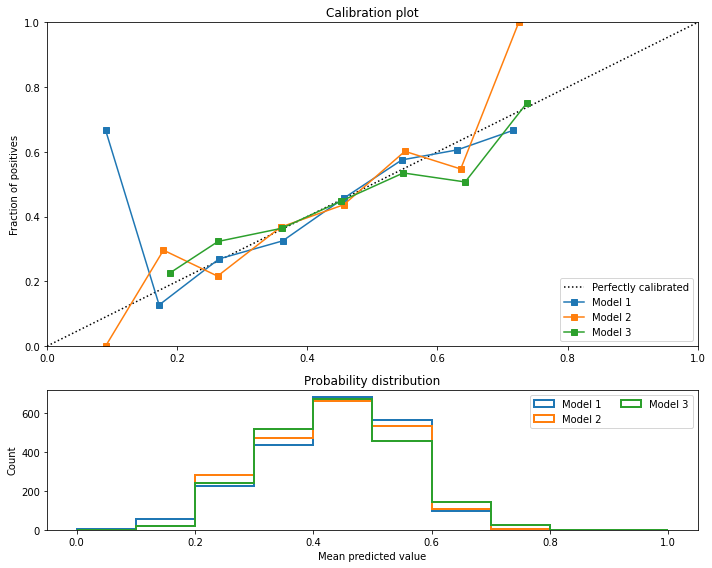

In [13]:
predictions = [clf1_predicted_proba[:,1], clf2_predicted_proba[:,1], clf3_predicted_proba[:,1]]

get_multiple_calibration_plot(predictions, y_test)
plt.savefig('./images/bmlpa_figures/ch07-4.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.230


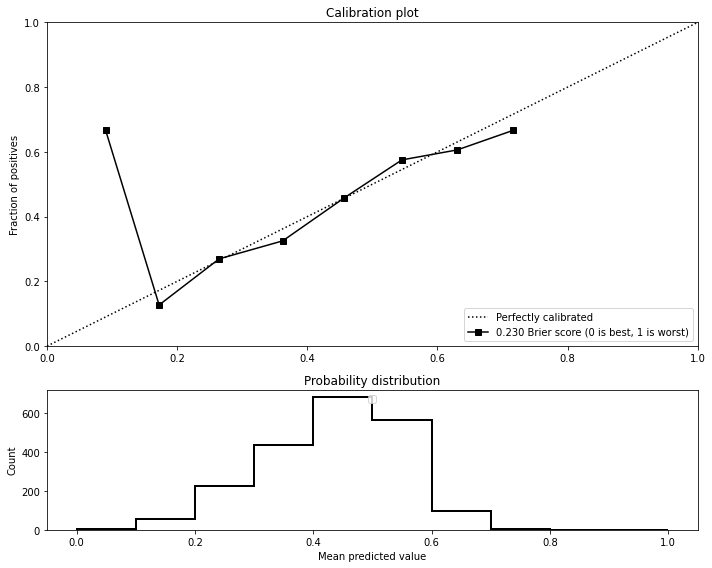

In [14]:
get_calibration_plot(clf1_predicted_proba[:,1], y_test, figsize=(10, 8))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.231


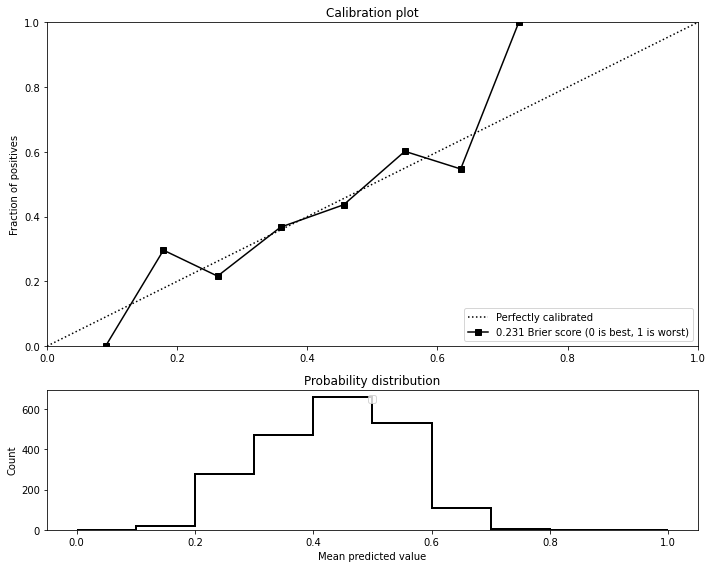

In [15]:
get_calibration_plot(clf2_predicted_proba[:,1], y_test, figsize=(10, 8))
plt.savefig('./images/bmlpa_figures/ch07-3.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.240


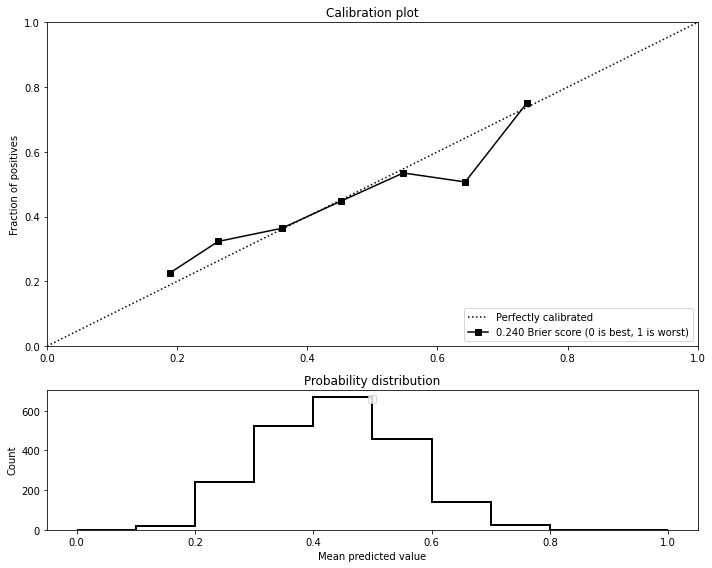

In [16]:
get_calibration_plot(clf3_predicted_proba[:,1], y_test, figsize=(10, 8))

세 번째 모델이 가장 나은 보정 곡선을 보여준다. 가능한 의미있는 점수를 보여주고 싶기 때문에 매우 중요한 부분이다.     
세 번째 모델은 가장 설명하기 좋은 특성을 사용하기 때문에 명확한 추천을 만들 수 있다.